In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

color_plt = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/PJME_hourly.csv')

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [6]:
# set the index to be Datetime

df = df.set_index('Datetime')
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [14]:
df.index = pd.to_datetime(df.index)

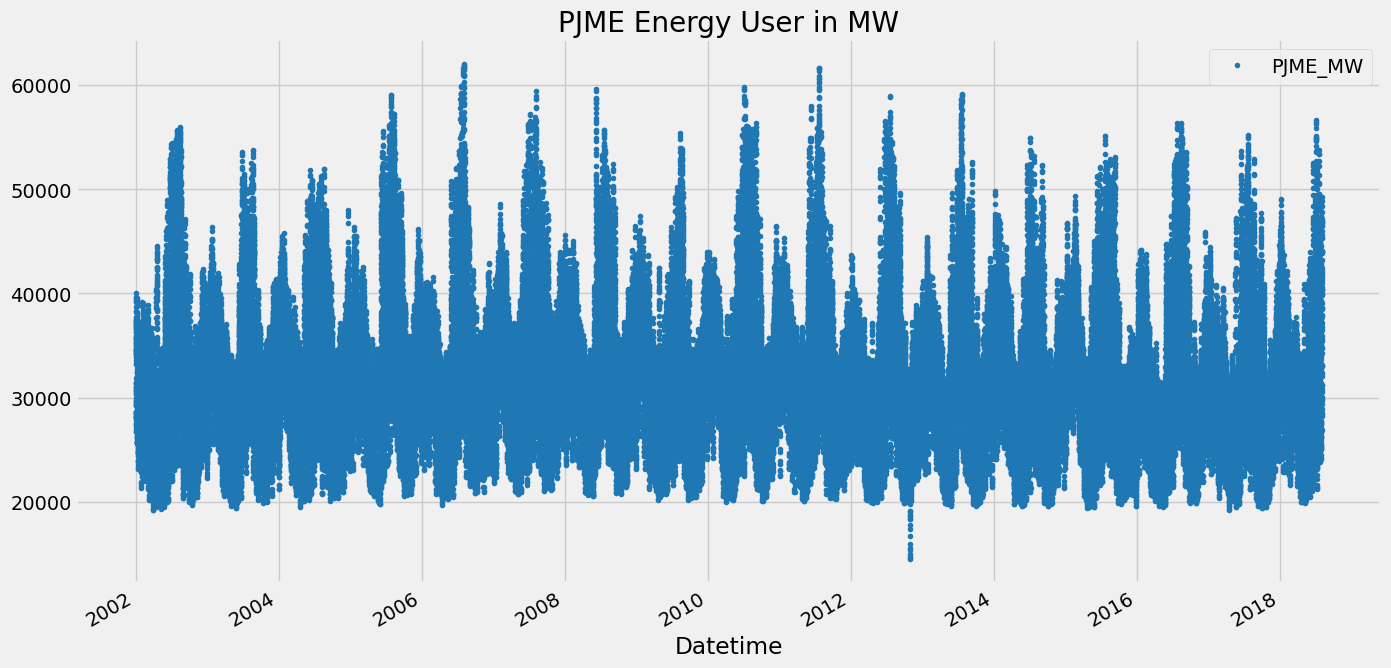

In [16]:
df.plot(style='.', figsize=(15,8), color = color_plt[0], title='PJME Energy User in MW')
# plt.xticks(rotation = 45)
plt.show()

# Train and Test Split Data

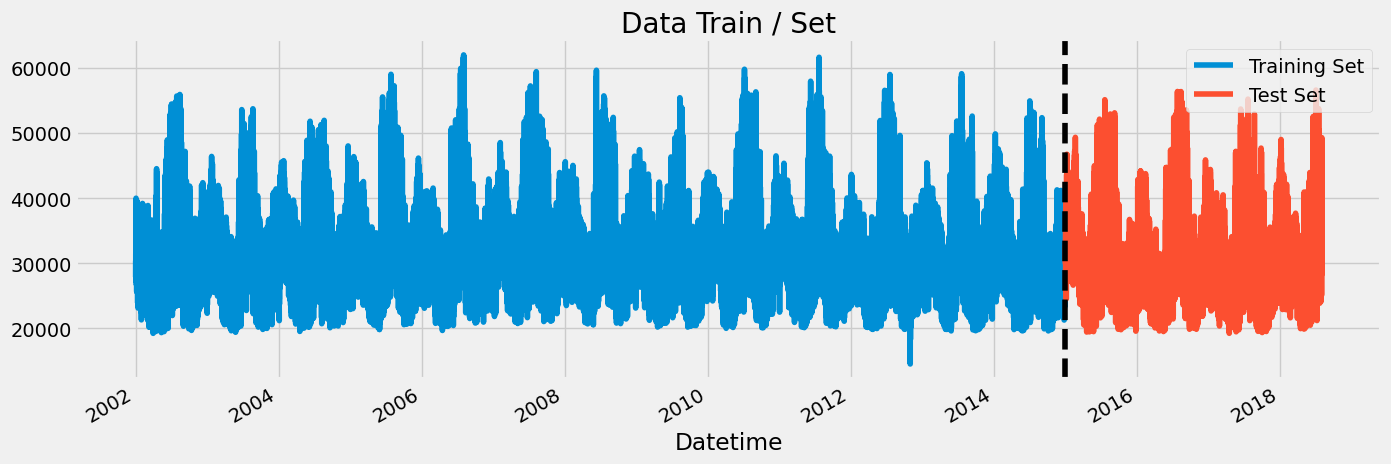

In [26]:
train = df.iloc[df.index < '01-01-2015']
test = df.iloc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label = 'Training Set', title='Data Train / Set')
test.plot(ax=ax, label = 'Test Set')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

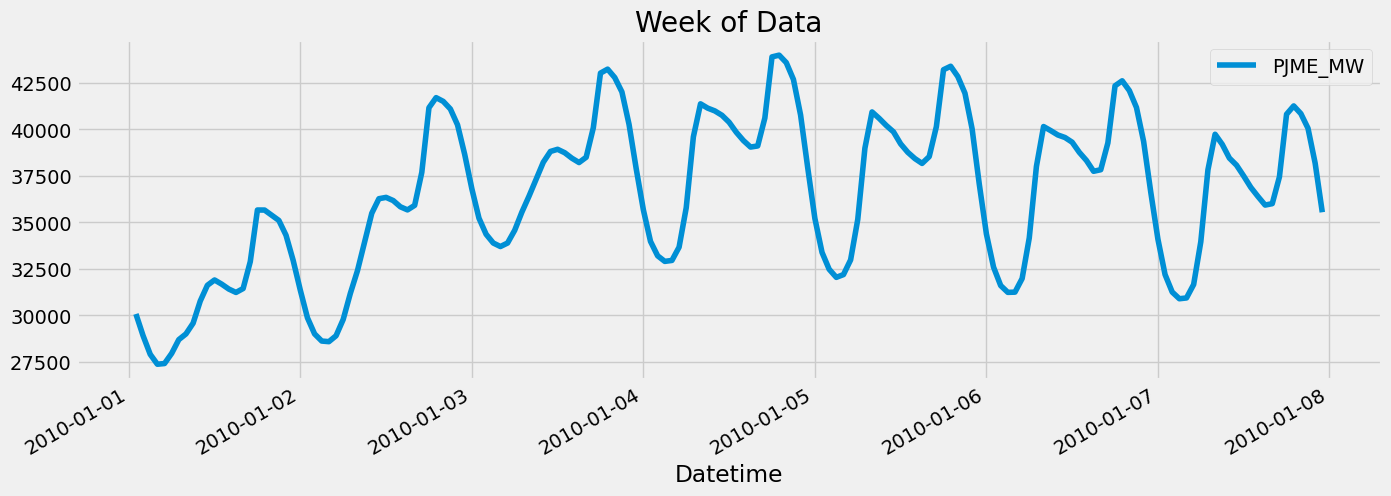

In [27]:
df.iloc[(df.index > '01-01-2010') & (df.index < '01-08-2010')
        ].plot(figsize=(15, 5), title='Week of Data')
plt.show()


# Feature Creation

In [35]:
def feature_creation(df):
    df= df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [36]:
df = feature_creation(df)

# Visualtize our feature / Target Relationship 

<Axes: title={'center': 'MW by Hour'}, xlabel='hour', ylabel='PJME_MW'>

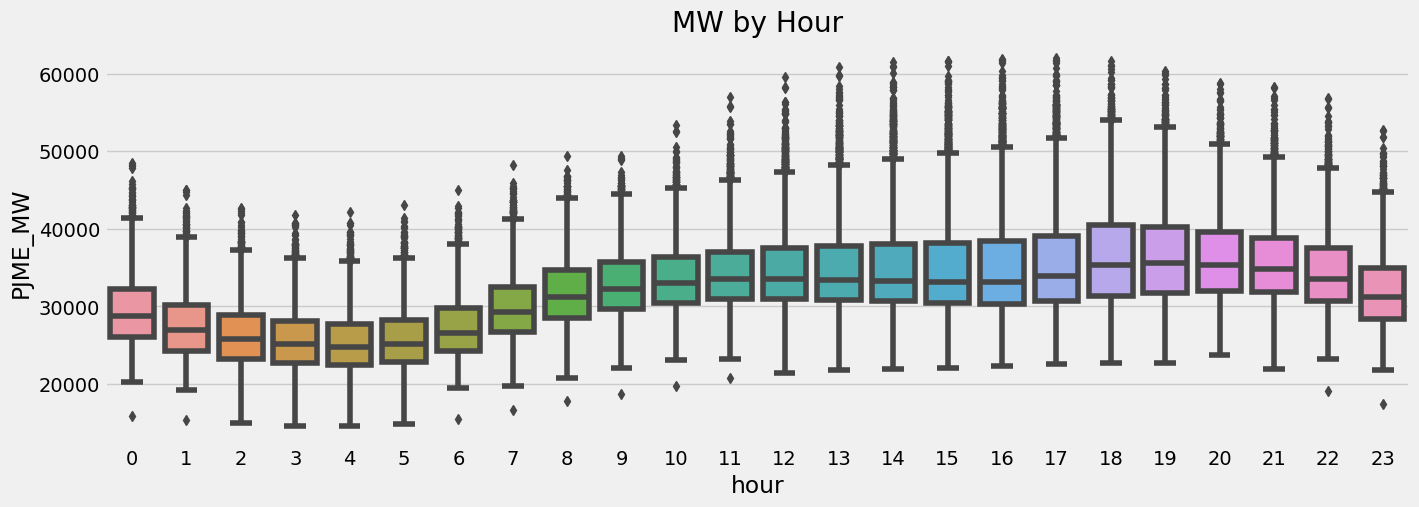

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('MW by Hour')
sns.boxplot(data=df, x='hour', y='PJME_MW')

<Axes: title={'center': 'MW by Month'}, xlabel='month', ylabel='PJME_MW'>

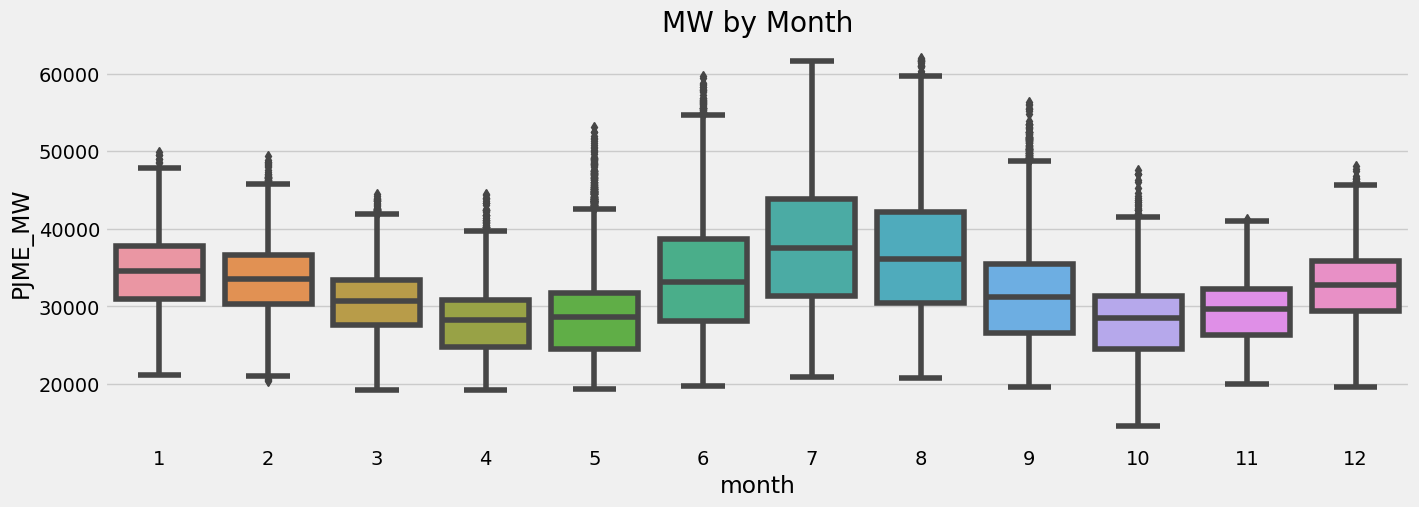

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('MW by Month')
sns.boxplot(data=df, x='month', y='PJME_MW')

# Create Our Model

In [39]:
train = feature_creation(train)
test = feature_creation(test)

In [40]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [42]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear']

TARGET = 'PJME_MW'


In [44]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]


In [47]:
from sklearn.metrics import mean_squared_error

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.01)
reg.fit(x_train, y_train,
        eval_set = [(x_train, y_train), (x_test, y_test)],
        verbose = 100)


[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

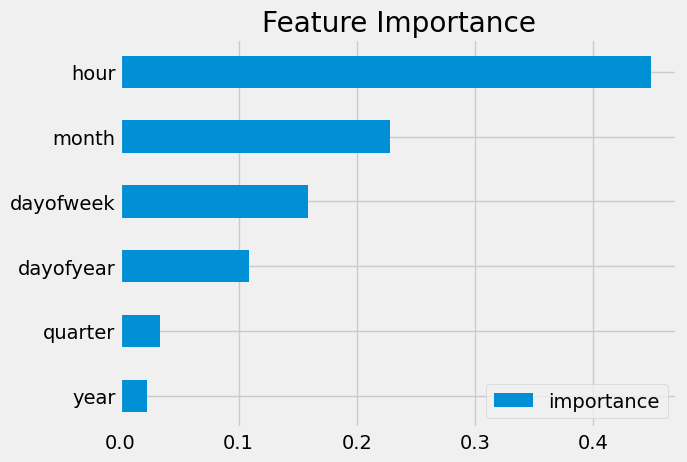

In [51]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_, columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


# Forecast on Test

In [57]:
test['prediction'] = reg.predict(x_test)

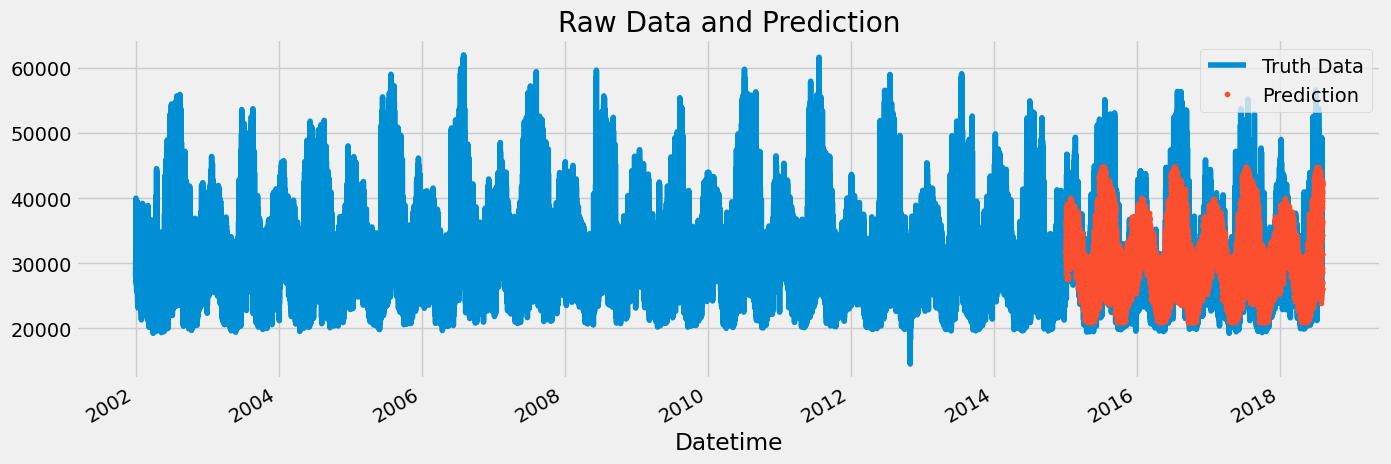

In [58]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()